In [9]:
from random import sample

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import shap

In [2]:
val_of_max_leaves = [41, 85, 129, 173, 217, 261, 305, 349, 393, 437, 481, 500]
max_leaf = val_of_max_leaves[-1]

classes = ['Amazon Echo', 'Android Phone', 'Belkin Wemo switch', 'Belkin wemo motion sensor', 'Dropcam', 'HP Printer',
           'Insteon Camera', 'Laptop', 'Light Bulbs LiFX Smart Bulb', 'MacBook', 'NEST Protect smoke alarm',
           'Netatmo Welcome', 'Netatmo weather station', 'PIX-STAR Photo-frame', 'Samsung Galaxy Tab',
           'Samsung SmartCam', 'Smart Things', 'TP-Link Day Night Cloud camera', 'TP-Link Smart plug',
           'Triby Speaker', 'Withings Aura smart sleep sensor', 'Withings Smart Baby Monitor',
           'Withings Smart scale', 'iHome']
features = ['Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Max Packet Length', 'Packet Length Mean',
            'Packet Length Total', 'dstport', 'ip.len', 'ip.ttl', 'srcport', 'tcp.flags.rst', 'tcp.hdr_len',
            'tcp.window_size_value', 'udp.length']

train_data_folder_path = '/home/ddeandres/UNSW_PCAPS/train/train_data_hybrid'
test_data_folder_path = '/home/ddeandres/UNSW_PCAPS/test/csv_files'
flow_counts_file_path = '/home/ddeandres/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv'
inference_point_n = 3
n_tree = 1

In [3]:
def get_x_y_flow(Dataset, feats):
    X = Dataset[feats]
    y = Dataset['Label_NEW'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

In [4]:
def get_test_labels(test_data):
    classes_df = pd.DataFrame(classes, columns=['class'])
    array_of_indices = []
    unique_labels = test_data["Label_NEW"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

In [5]:
def prepare_data(npkts, classes_filter=None):
    def assign_sample_nature(row):
        """Aux function to check the conditions and assign values"""
        if (row["Min Packet Length"] == -1 and
                row["Max Packet Length"] == -1 and
                row["Flow IAT Min"] == -1 and
                row["Flow IAT Max"] == -1):
            return "pkt"
        else:
            return "flw"

    # Load Train and Test data
    train_data = pd.read_csv(f"{train_data_folder_path}/train_data_{npkts}.csv")
    test_data = pd.read_csv(f"{test_data_folder_path}/16-10-05.pcap.txt_{npkts}_pkts.csv")
    if classes_filter is not None:
        train_data = train_data.loc[train_data['Label'].isin(classes_filter)]
        test_data = test_data.loc[test_data['Label'].isin(classes_filter)]

    flow_pkt_counts = pd.read_csv(flow_counts_file_path)

    flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
    # Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
    test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)

    #### To get packet count of each flow in train data
    packet_data = pd.read_csv(f'{train_data_folder_path}/UNSW_train_ALL_PKT_DATE.csv')
    packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
    packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
    packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
    train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

    flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
    # Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
    train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)

    all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (
            test_data['Packet Length Mean'] == -1)
    # Assign values to the multiply column based on the conditions
    test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

    train_data = train_data.sample(frac=1, random_state=42)
    test_data = test_data.sample(frac=1, random_state=42)

    train_data = train_data.dropna(subset=['srcport', 'dstport'])
    test_data = test_data.dropna(subset=['srcport', 'dstport'])

    train_data['Label_NEW'] = np.where((train_data['Label'].isin(classes)), train_data['Label'], 'Other')
    test_data['Label_NEW'] = np.where((test_data['Label'].isin(classes)), test_data['Label'], 'Other')

    train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
    test_data['sample_nature'] = test_data.apply(assign_sample_nature, axis=1)

    train_data['weight'] = np.where(train_data['sample_nature'] == 'flw',
                                    (train_data['pkt_count'] - npkts + 1) / train_data['pkt_count'],
                                    1 / train_data['pkt_count'])
    return train_data, test_data

In [42]:
train_data, test_data = prepare_data(inference_point_n, classes)
test_labels, test_indices = get_test_labels(test_data)
weight_of_samples = list(train_data['weight'])
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, features)
X_test, y_test, sample_nat_test = get_x_y_flow(test_data, features)

In [43]:
sample_ids = sample(range(X_train.shape[0]), 10000)
X_shap_sample = X_train.iloc[sample_ids]
y_shap_sample = y_train.iloc[sample_ids]

In [44]:
model = RandomForestClassifier(n_estimators=n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
                                   random_state=42, bootstrap=False)

model.fit(X_train[features], y_train, sample_weight=weight_of_samples)
y_pred = model.predict(X_test[features])

y_test = [int(label) for label in y_test.values]
y_pred = [int(label) for label in y_pred]

class_report = classification_report(y_test, y_pred, labels=test_indices, target_names=test_labels,
                                     output_dict=True)
print(class_report)

{'Laptop': {'precision': 0.939277566539924, 'recall': 0.8332096600107933, 'f1-score': 0.8830699935654537, 'support': 29648.0}, 'Insteon Camera': {'precision': 0.66280276816609, 'recall': 0.901553184813304, 'f1-score': 0.7639590534432332, 'support': 12748.0}, 'Samsung SmartCam': {'precision': 0.9333014963387456, 'recall': 0.7425748844278386, 'f1-score': 0.8270851701639923, 'support': 31582.0}, 'Amazon Echo': {'precision': 0.509067903838043, 'recall': 0.9284615384615384, 'f1-score': 0.6575864886951784, 'support': 10400.0}, 'Samsung Galaxy Tab': {'precision': 0.7859598096245373, 'recall': 0.6088069636456733, 'f1-score': 0.6861330717294708, 'support': 19530.0}, 'Belkin wemo motion sensor': {'precision': 0.8953206938281565, 'recall': 0.9017775520568817, 'f1-score': 0.898537523404686, 'support': 9845.0}, 'Netatmo Welcome': {'precision': 0.7601063829787233, 'recall': 0.7335728952772074, 'f1-score': 0.7466039707419018, 'support': 3896.0}, 'HP Printer': {'precision': 0.9833024118738405, 'recall

100%|===================| 239601/240000 [00:28<00:00]        

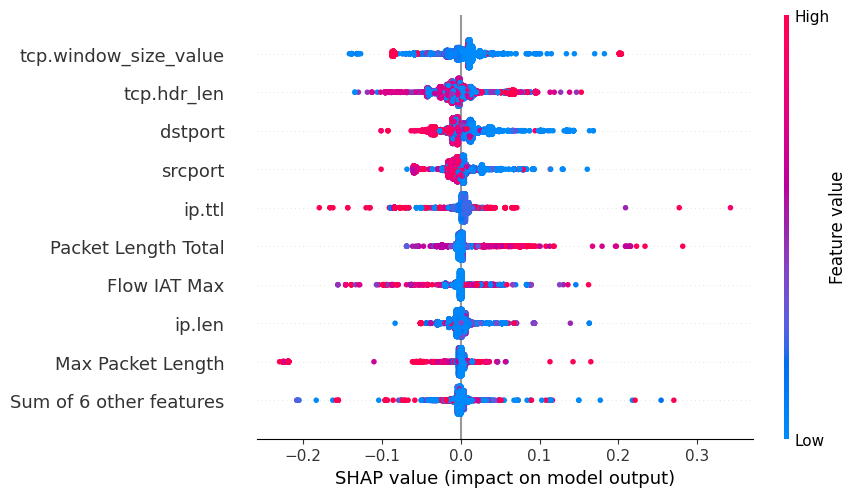

In [46]:
# compute SHAP values
explainer = shap.Explainer(model, X_shap_sample)


# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_shap_sample, y=y_shap_sample)
shap_values = explainer(X_shap_sample)
shap.plots.beeswarm(shap_values[:,:,1])
# shap.summary_plot(shap_values, X_shap_sample)
# plt.show()

In [47]:
shap_values[:,:,0]

.values =
array([[ 9.93722691e-04, -9.92802535e-03, -3.69942170e-03, ...,
        -3.66579488e-03, -4.51684679e-03, -2.76512943e-03],
       [ 1.16647166e-03,  9.32145337e-05, -3.13437263e-03, ...,
        -7.47092075e-02, -1.01974465e-02, -2.03089812e-03],
       [ 1.05593407e-03, -4.80852404e-04, -2.92055163e-03, ...,
         3.21745412e-03, -4.22723988e-02, -1.04396994e-03],
       ...,
       [ 1.15258323e-03,  9.32145337e-05, -3.13437263e-03, ...,
        -7.43535640e-02, -1.01974465e-02, -2.03089812e-03],
       [ 4.69627990e-03,  1.61567540e-03, -2.56950627e-02, ...,
        -1.81528191e-01, -9.40454631e-03, -1.01350790e-02],
       [ 8.72705961e-04, -7.07548953e-04, -3.64498076e-03, ...,
        -6.68499888e-03,  2.38433293e-03, -1.53693888e-03]])

.base_values =
array([0.13015463, 0.13015463, 0.13015463, ..., 0.13015463, 0.13015463,
       0.13015463])

.data =
array([[ 6.9720e+06,  6.8390e+06,  3.4860e+06, ...,  8.0000e+00,
         2.9200e+03,  0.0000e+00],
       [-1.0000e